# **ENPH 353 Plate Reader**
Once coordinates are found (assuming there are four corners in the image), the ML corner detector will pass the image along to this CNN. It will apply the inverse Perspective Transform and then Read the plate number and Location. 

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import math
import numpy as np
import re
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw

from IPython.display import display
from IPython.display import Image as _Imgdis
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from keras.utils import np_utils
import cv2

from random import randint
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import random

1.14.0


# Importing Plate Data as Numpy Array: 
Tutorial from https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays

In [6]:
#First part just gets the filenames and such ready:
folder = "./training_images"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames = [] # the image filename 
labels = []     # the label

for _file in onlyfiles: # file names
    if _file.split('.')[1] == 'xml':
        filenames.append(_file)


# Only here do we start to atually take in images
border = 50 # Determines how close the image crop is
            # Larger should give more leeway. Changes Bounding Boxes! 
NOISE = 5   # pm pixel offset.

res_x = 300
res_y = int(res_x*1.5)

nb_classes = 1

dataset = np.ndarray(shape=(len(filenames), (res_y+border), (res_x+border)),
                     dtype=np.short) # this just makes the empty array.

Middle = 128.0

j = 0 # index of the output array 
# Here is where we must do the XML fun. 
for i in range(int(len(filenames))):
    location = folder + "/" + filenames[i]

    tree = ET.parse(location)
    root = tree.getroot()

    corners = 0
    for exists in root.iter('exists'):
        corners+= int(exists.text)
        
    if corners == 4: # applying cv2 transformations here, might get ugly
        topleft = (0,0)
        topright = (0,0)
        bottomleft = (0,0)
        bottomright = (0,0)
        
        for cord in root.findall('topleft'):
            topleft = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))
        for cord in root.findall('topright'):
            topright = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))
        for cord in root.findall('bottomleft'):
            bottomleft = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))
        for cord in root.findall('bottomright'):
            bottomright = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))

        pts1 = np.float32([[topleft[0],topleft[1]], 
                        [topright[0],topright[1]], 
                        [bottomleft[0],bottomleft[1]], 
                        [bottomright[0],bottomright[1]]]) #sorry
        
        pts2 = np.float32([[0,0], [res_x,0], [0,res_y], [res_x,res_y]])
        pts2 += int(border/2)
        
        with np.nditer(pts1, op_flags=['readwrite']) as it:
            for point in it:
                point += random.randint(-5,5) # Adding error to perspective transform to simulate innacuracy
        
        M = cv2.getPerspectiveTransform(pts1, pts2)
        
        location2 = '.' + location.split('.')[1] + '.png'
        im = cv2.imread(location2)
        
        dst = cv2.warpPerspective(im, M, (res_x+border,res_y+border))
       
        im_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY) # wondering if some contrast would be nice here
#         im_gray = (im_gray - Middle) / Middle
        dataset[j] = im_gray    
        labels.append(filenames[i][5:16])
        
#         if j in range(0,15):
#             im = cv2.circle(im, (topleft[0],topleft[1]), 1, (0,0,255), 30)
#             im = cv2.circle(im, (topright[0],topright[1]), 1, (0,0,255), 30)
#             im = cv2.circle(im, (bottomleft[0],bottomleft[1]), 1, (0,0,255), 30)
#             im = cv2.circle(im, (bottomright[0],bottomright[1]), 1, (0,0,255), 30)
            
#             plt.figure()
#             plt.imshow(im) 
#             plt.show()
            
#             plt.figure()
#             plt.imshow(im_gray) 
#             plt.show()
            
        j += 1 

Length of 4 Cornered Images:  722
Dataset shape:  (722, 500, 350)


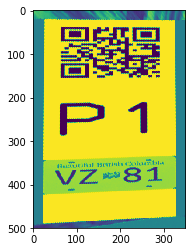

In [7]:
print("Length of 4 Cornered Images: ", len(labels))
dataset = dataset[0:len(labels)]
print("Dataset shape: ", dataset.shape)
plt.figure()
plt.imshow(dataset[2]) 
plt.show()

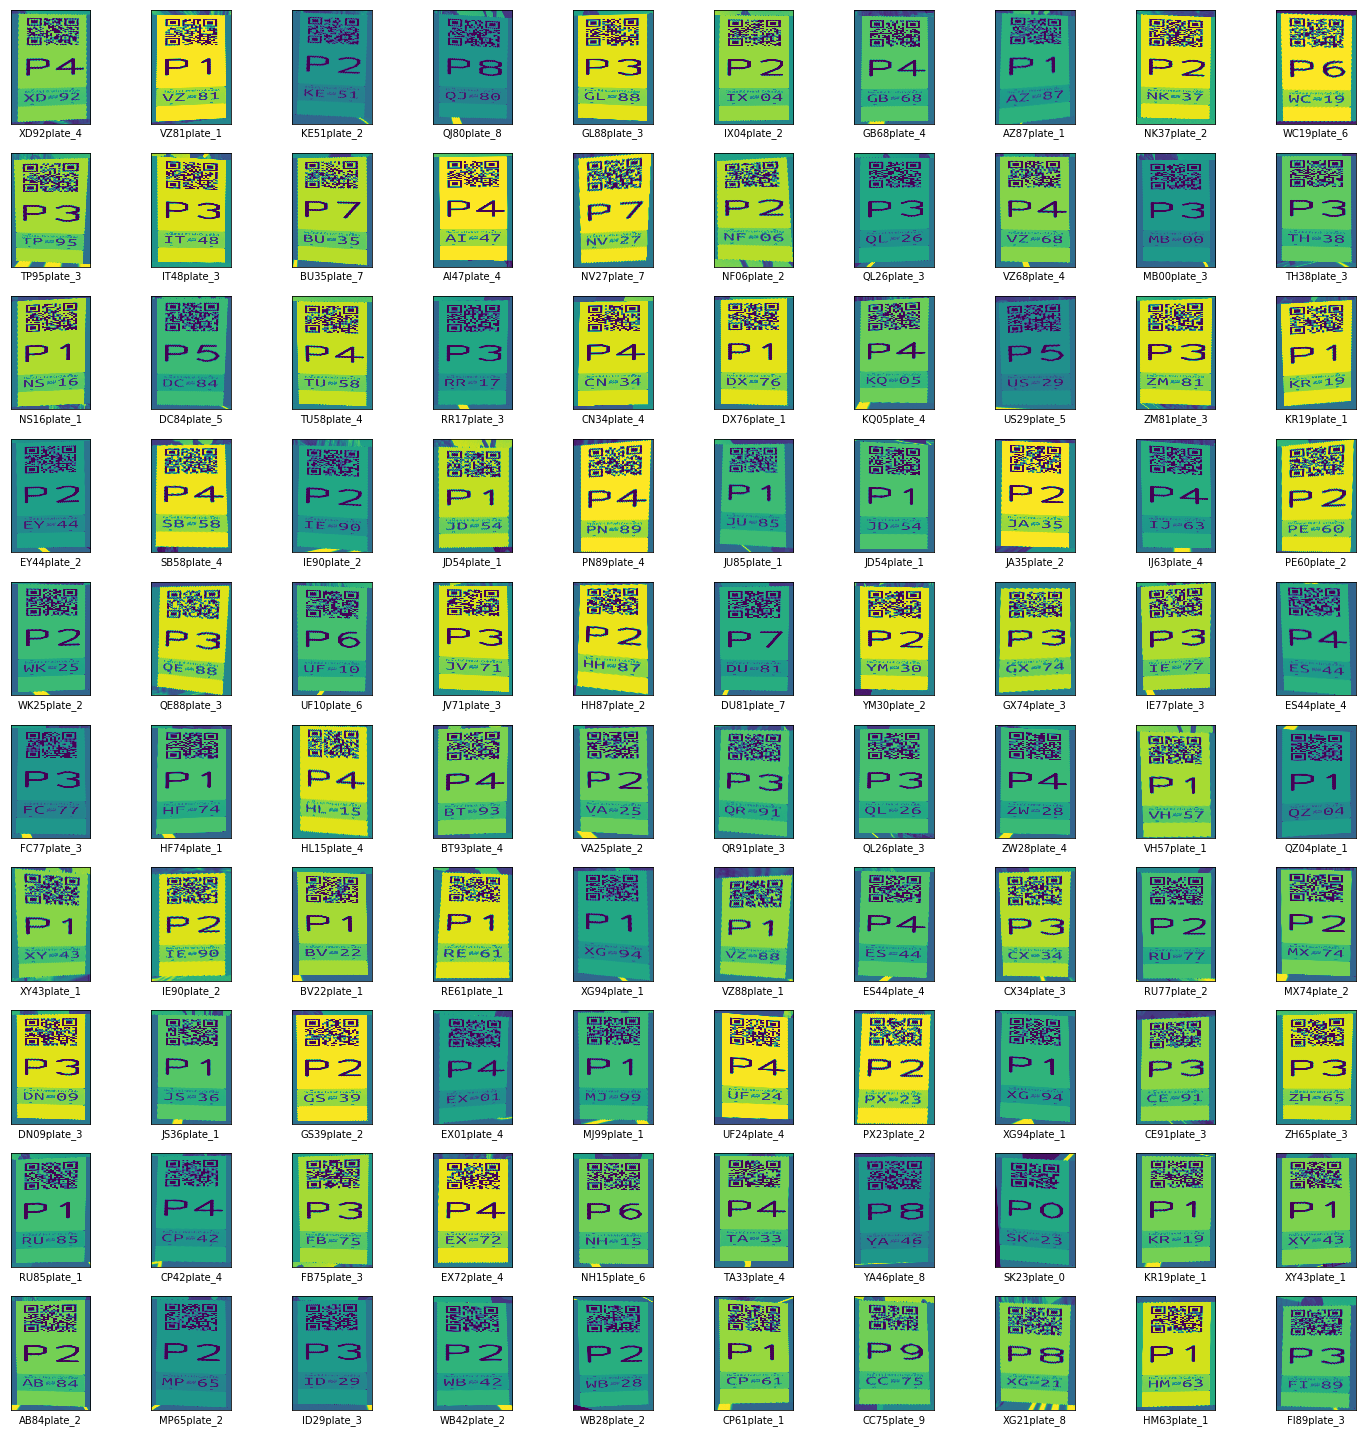

In [8]:
num_rows = 10 # i 
num_cols = 10 # 4 + 1

plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_cols*num_rows):
    plt.subplot(num_rows, num_cols, i+1) # 1 indexing
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(dataset[i+1])
    plt.xlabel(labels[i+1])    
plt.tight_layout()
plt.show()

It works! We now a license plate with Labels 
# Split up the the indivudal characters. 
This is also where one would be translating the windows a bit and then adding this new dataset. 

In [9]:
repeatdata = 1
randomness = 3 #pixels

#Don't make anything too snug as there will be variation! 
pipe_x = 80
pipe_y = 80

setlen = len(labels)
letters = np.ndarray(shape=(setlen*repeatdata, 5, pipe_y, pipe_x),
                     dtype=np.float32)
print (letters.shape)
# this just makes the empty array for image files.

#First let's find the appropriate location for the letters:
plate1 = (340,40)
plate2 = (340,90)
plate3 = (335,180)
plate4 = (335,240)
location = (180,180)

def feature_image(featureloc, scale=1, pixoffset=0): #pixoffset >= 0
    Ypoint = featureloc[0]
    Xpoint = featureloc[1]
    if pixoffset != 0:
        Ypoint += random.randint(-pixoffset,pixoffset)
        Xpoint += random.randint(-pixoffset,pixoffset)
        
    Ydown   = slice(Ypoint,Ypoint+pipe_y*scale, scale)
    Xacross = slice(Xpoint,Xpoint+pipe_x*scale, scale)
    return dataset[:,Ydown,Xacross]


letters[:setlen,0] = feature_image(plate1)
letters[:setlen,1] = feature_image(plate2)
letters[:setlen,2] = feature_image(plate3)
letters[:setlen,3] = feature_image(plate4)
letters[:setlen,4] = feature_image(location, scale=2)

for i in range(1, repeatdata):
    b = i*setlen
    e = (i+1)*setlen
    letters[b:e,0] = feature_image(plate1, randomness)
    letters[b:e,1] = feature_image(plate2, randomness)
    letters[b:e,2] = feature_image(plate3, randomness)
    letters[b:e,3] = feature_image(plate4, randomness)
    letters[b:e,4] = feature_image(location, scale=2, randomness)
    
#The Labels. For ros translational simplicity, I want each index here to represent an image. 
#This will be flattened but for now it just makes morse sense
letterlabels = np.ndarray((len(labels), 5), dtype=np.int8) 

def toint(char):
    if char.isalpha():
        return ord(char) - 55 # A is 10, B is 11, ... Can use chr(65) to invert
    else:
        return int(char)

def tochar(inty):
    inty = int(inty)
    if inty < 10:
        return str(inty)
    else:
        return chr(55+inty)
    
i = 0
for label in labels:
    letterlabels[i,0] = toint(label[0])
    letterlabels[i,1] = toint(label[1])
    letterlabels[i,2] = toint(label[2])
    letterlabels[i,3] = toint(label[3])
    letterlabels[i,4] = toint(label[10])
    i += 1

(722, 5, 80, 80)


Let's make a thing so we can look at how well we are doing with the cropping.
Thanks google: https://www.tensorflow.org/tutorials/keras/classification

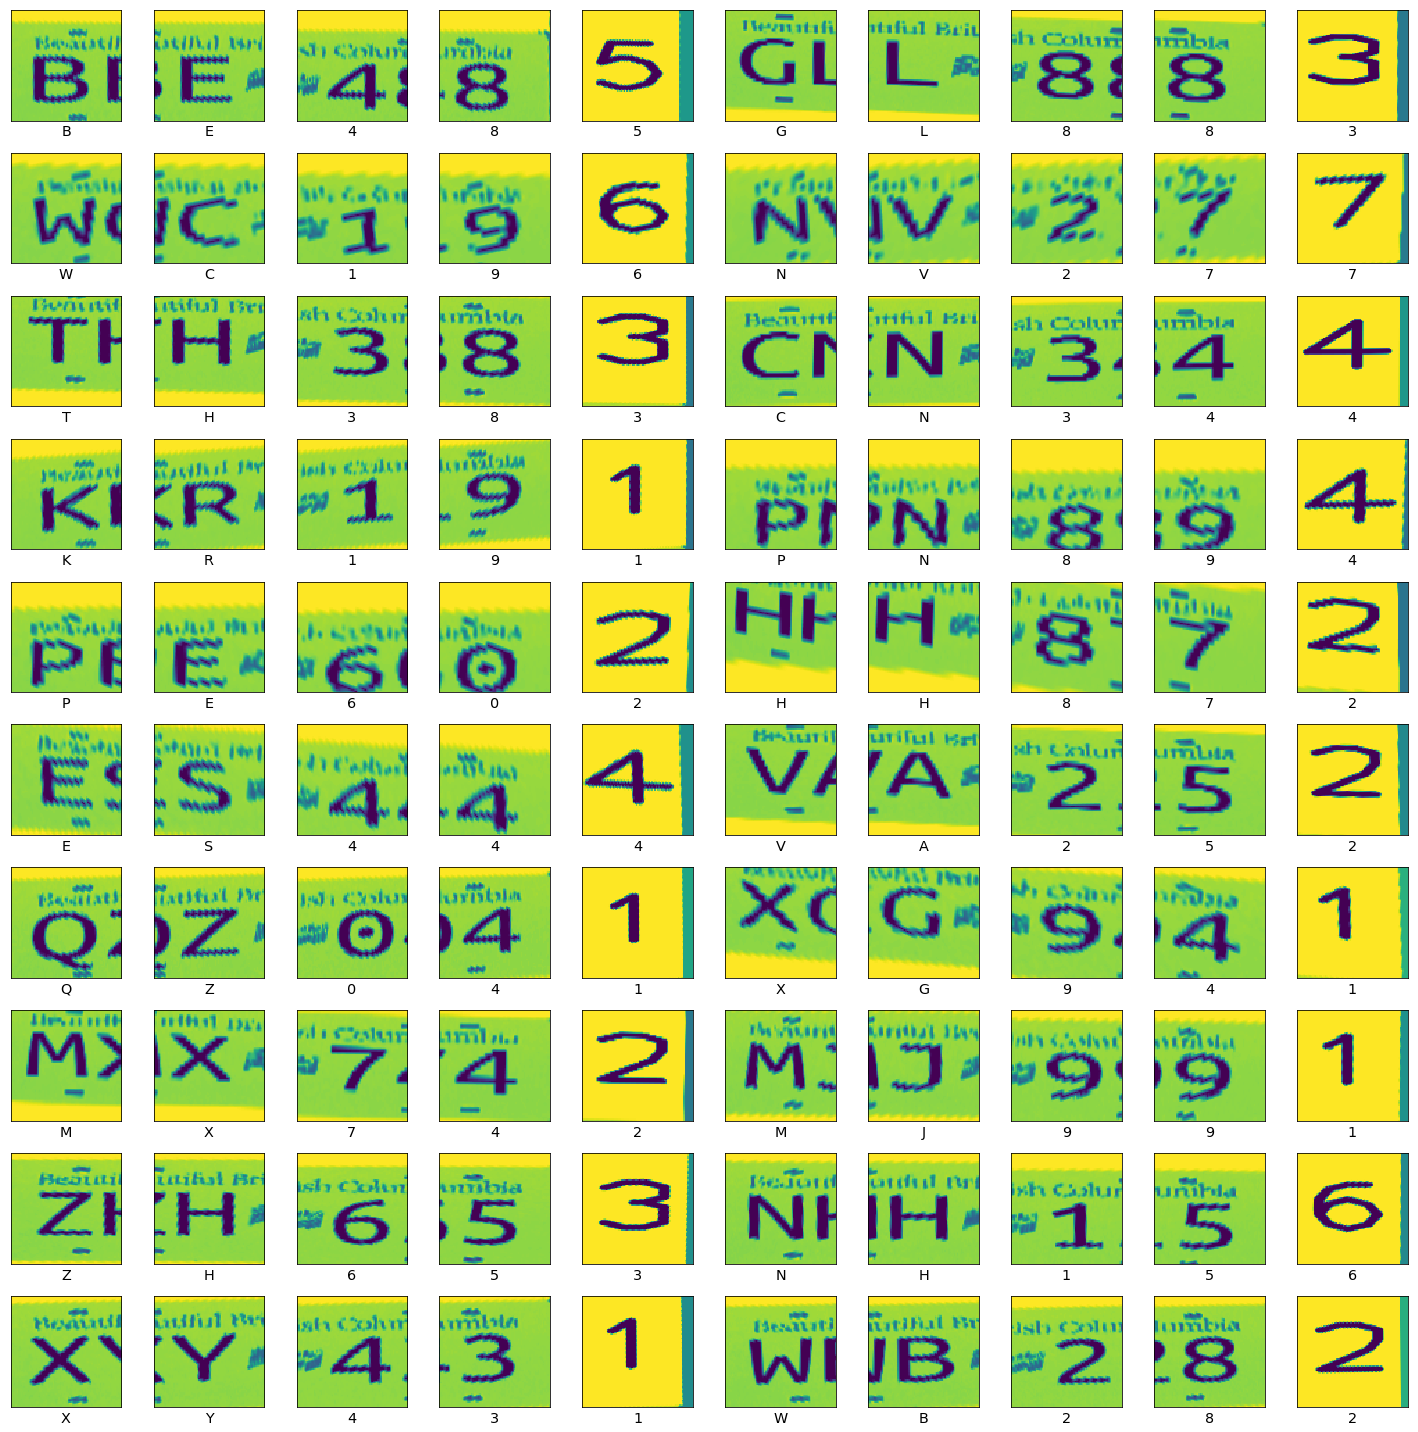

In [10]:
def plot_image(img, title):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)
    #plt.title(tochar(title), fontsize='large')
    plt.xlabel(tochar(title), fontsize='x-large')

num_rows = 10 # i 
num_cols = 5 * 2 # multiple of 4 + 1 

plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(0, num_rows*num_cols, 5):
    for j in range(5):
        plt.subplot(num_rows, num_cols, i+j+1) # 1 indexing
        plot_image(letters[i,j], letterlabels[i,j])
    
plt.tight_layout()
plt.show()


# Push into Keras CNN

(722, 5, 80, 80) -> (3610, 80, 80, 1)
(722, 5) -> (3610,)


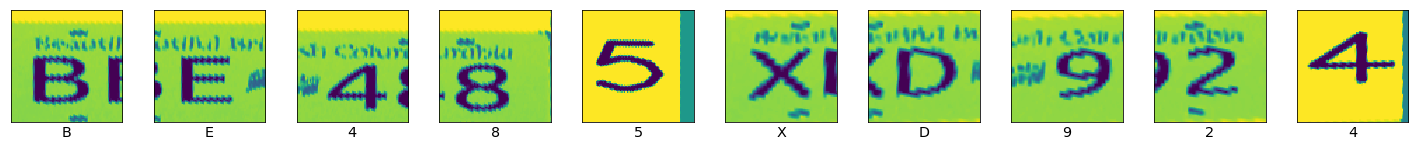

[11 14  4 ...  7  3  3]


In [11]:
letterline = np.reshape(letters, (-1,80,80,1))
labelline = np.ravel(letterlabels, order='C')

print (letters.shape, "->", letterline.shape)
print (letterlabels.shape, "->", labelline.shape)

#Ensure Order is Preserved:
num_rows = 1 # i 
num_cols = 5 * 2 # multiple of 4 + 1 
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(0, num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1) # 1 indexing
    plot_image(letterline[i,:,:,0], labelline[i])
    
plt.tight_layout()
plt.show()

print(labelline)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(letterline, labelline, test_size=0.33)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(80, 80, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(36, activation='softmax'))

model.summary()

(2418, 80, 80, 1) (2418,)
(1192, 80, 80, 1) (1192,)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 76, 76, 32)        832       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 16, 16, 32)        1056      
_________________________________________________________________
m

In [53]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
2418/2418 [==============================] - 7s 3ms/sample - loss: 3.0560 - acc: 0.1944
Epoch 2/10
2418/2418 [==============================] - 8s 3ms/sample - loss: 2.0378 - acc: 0.4438
Epoch 3/10
2418/2418 [==============================] - 9s 4ms/sample - loss: 1.1337 - acc: 0.6774 2s - loss: 
Epoch 4/10
2418/2418 [==============================] - 9s 4ms/sample - loss: 0.5737 - acc: 0.8337
Epoch 5/10
2418/2418 [==============================] - 8s 3ms/sample - loss: 0.4330 - acc: 0.8751
Epoch 6/10
2418/2418 [==============================] - 7s 3ms/sample - loss: 0.2160 - acc: 0.9392
Epoch 7/10
2418/2418 [==============================] - 8s 3ms/sample - loss: 0.1703 - acc: 0.9491
Epoch 8/10
2418/2418 [==============================] - 9s 4ms/sample - loss: 0.1643 - acc: 0.9471
Epoch 9/10
2418/2418 [==============================] - 8s 3ms/sample - loss: 0.1713 - acc: 0.9446
Epoch 10/10
2418/2418 [==============================] - 8s 3ms/sample - loss: 0.0881 - acc: 0.97

In [54]:
#Below is predicted Data! 
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

predictions = model.predict(x_test)

1192/1192 - 1s - loss: 0.2898 - acc: 0.9346

Test accuracy: 0.93456376


# Reincorporate into one Plate